## Diagnosis Based on Colon Images: Image Classification

Dataset Source: https://www.kaggle.com/datasets/francismon/curated-colon-dataset-for-deep-learning

##### Install Necessary Libraries Not Already Installed

In [17]:
%pip install datasets transformers tensorboard


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [18]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, concatenate_datasets

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

##### Display Versions of Relevant Libraries

In [19]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.5.2
  Transformers: 4.22.2
         Torch: 1.12.1


##### Ingest Dataset

In [20]:
dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/Vit Image Datasets/WCE Curated Colon Disease Dataset Deep Learning", 
                        drop_labels=False)

print("Training Dataset")
print(dataset['train'])
print(dataset['train'][0])
print(dataset['train'][-1])

print("Testing Dataset")
print(dataset['test'])
print(dataset['test'][0])
print(dataset['test'][-1])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Using custom data configuration default-74e04d20ceafb70f
Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-74e04d20ceafb70f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


A Jupyter Widget

Training Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 3200
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=615x531 at 0x7F9BF9AF8400>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1225x1013 at 0x7F9BF9AF8940>, 'label': 3}
Testing Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 800
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x576 at 0x7F9BF9AF8D30>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1024 at 0x7F9BF9AF8A30>, 'label': 3}


##### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [21]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font, dill=(0,0,255,1.0))
    
    return grid

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-74e04d20ceafb70f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-f6f4cfa216852250.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-74e04d20ceafb70f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-b6c189ec0ad96128.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-74e04d20ceafb70f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-bb4c965775a8a59f.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-74e04d20ceafb70f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-ab02e3a28d72e4ec.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-74e04

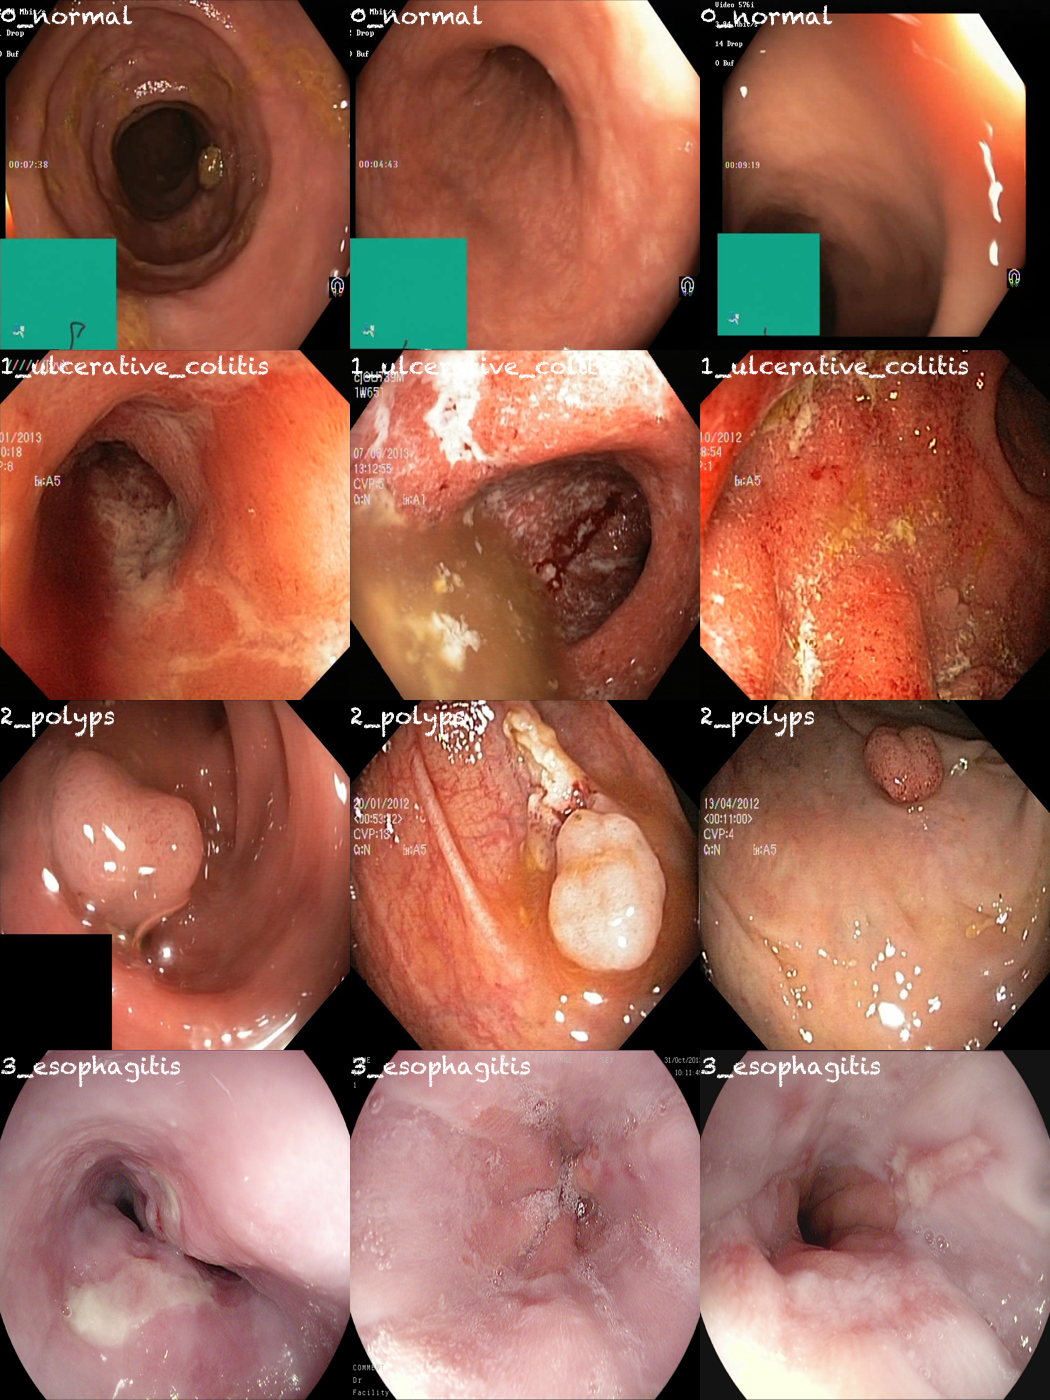

In [22]:
show_grid_of_examples(dataset, seed=42, examples_per_class=3)

##### Remember to Install git lfs & Enter HuggingFace Access Token

In [23]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


##### Basic Values/Constants

In [24]:
MODEL_CKPT='google/vit-base-patch16-224-in21k'
NUM_OF_EPOCHS=3

LEARNING_RATE=2e-4
STEPS=100

BATCH_SIZE=16
DEVICE = torch.device("mps")

REPORTS_TO='tensorboard'

##### Load ViT Feature Extractor

In [25]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

loading configuration file preprocessor_config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



##### Preprocessing Dataset

In [26]:
def transform(sample_batch):
    # take a list of PIL images and turn them into pixel values
    inputs = feature_extractor([x for x in sample_batch['image']], return_tensors="pt")
    
    # prepare labels
    inputs['labels'] = sample_batch['label']
    return inputs

##### Apply Transform Function to Dataset

In [27]:
prepped_ds = dataset.with_transform(transform)

#### Training & Evaluation

##### Define Data Collator

In [28]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

##### Define Evaluation Metric

In [29]:
def compute_metrics(p):
    accuracy_metric = load_metric("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = load_metric("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = load_metric("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = load_metric("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

##### Load Pretrained Model

In [30]:
labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "0_normal",
    "1": "1_ulcerative_colitis",
    "2": "2_polyps",
    "3": "3_esophagitis"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0_normal": "0",
    "1_ulcerative_colitis": "1",
    "2_polyps": "2",
    "3_esophagitis": "3"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.22.2"
}

loading weight

##### Define Training Arguments

In [31]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "_GI_diagnosis",
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    logging_first_step=True,
    push_to_hub=True
)

PyTorch: setting up devices


##### Instantiate Trainer

In [32]:
trainer = Trainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['test'],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_GI_diagnosis into local empty directory.


##### Train Model

In [33]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3200
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 600


A Jupyter Widget

{'loss': 1.3805, 'learning_rate': 0.00019966666666666668, 'epoch': 0.01}


***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

/var/folders/93/v_c2ph_17t97zdkzc4_ccjtw0000gn/T/ipykernel_35829/98622762.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
Saving model checkpoint to google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-200
Configuration saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-200/config.json


{'eval_loss': 0.5006434917449951, 'eval_accuracy': 0.86375, 'eval_Weighted F1': 0.8531346324635811, 'eval_Micro F1': 0.86375, 'eval_Macro F1': 0.853134632463581, 'eval_Weighted Recall': 0.86375, 'eval_Micro Recall': 0.86375, 'eval_Macro Recall': 0.86375, 'eval_Weighted Precision': 0.911093881243135, 'eval_Micro Precision': 0.86375, 'eval_Macro Precision': 0.911093881243135, 'eval_runtime': 724.2269, 'eval_samples_per_second': 1.105, 'eval_steps_per_second': 0.138, 'epoch': 1.0}


Model weights saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-200/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-200/preprocessor_config.json
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

Saving model checkpoint to google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-400
Configuration saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-400/config.json
Model weights saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-400/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-400/preprocessor_config.json


{'eval_loss': 0.2538217604160309, 'eval_accuracy': 0.9375, 'eval_Weighted F1': 0.936472467651561, 'eval_Micro F1': 0.9375, 'eval_Macro F1': 0.9364724676515609, 'eval_Weighted Recall': 0.9375, 'eval_Micro Recall': 0.9375, 'eval_Macro Recall': 0.9375, 'eval_Weighted Precision': 0.9454970963639796, 'eval_Micro Precision': 0.9375, 'eval_Macro Precision': 0.9454970963639796, 'eval_runtime': 724.1098, 'eval_samples_per_second': 1.105, 'eval_steps_per_second': 0.138, 'epoch': 2.0}


Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/preprocessor_config.json


{'loss': 0.0628, 'learning_rate': 3.3333333333333335e-05, 'epoch': 2.5}


***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

Saving model checkpoint to google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-600
Configuration saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-600/config.json


{'eval_loss': 0.5797314643859863, 'eval_accuracy': 0.88125, 'eval_Weighted F1': 0.8740311301580648, 'eval_Micro F1': 0.88125, 'eval_Macro F1': 0.8740311301580649, 'eval_Weighted Recall': 0.88125, 'eval_Micro Recall': 0.88125, 'eval_Macro Recall': 0.8812500000000001, 'eval_Weighted Precision': 0.9157051711944594, 'eval_Micro Precision': 0.88125, 'eval_Macro Precision': 0.9157051711944594, 'eval_runtime': 724.2187, 'eval_samples_per_second': 1.105, 'eval_steps_per_second': 0.138, 'epoch': 3.0}


Model weights saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-600/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-600/preprocessor_config.json
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from google/vit-base-patch16-224-in21k_GI_diagnosis/checkpoint-400 (score: 0.2538217604160309).


{'train_runtime': 27748.8376, 'train_samples_per_second': 0.346, 'train_steps_per_second': 0.022, 'train_loss': 0.05536448404192924, 'epoch': 3.0}


In [34]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to google/vit-base-patch16-224-in21k_GI_diagnosis
Configuration saved in google/vit-base-patch16-224-in21k_GI_diagnosis/config.json
Model weights saved in google/vit-base-patch16-224-in21k_GI_diagnosis/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/preprocessor_config.json
Saving model checkpoint to google/vit-base-patch16-224-in21k_GI_diagnosis
Configuration saved in google/vit-base-patch16-224-in21k_GI_diagnosis/config.json
Model weights saved in google/vit-base-patch16-224-in21k_GI_diagnosis/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_GI_diagnosis
   d956e16..271dc4f  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_GI_diagnosis
   271dc4f..15f667e  main -> main



***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.0554
  train_runtime            = 7:42:28.83
  train_samples_per_second =      0.346
  train_steps_per_second   =      0.022


##### Evaluate Model

In [35]:
metrics = trainer.evaluate(prepped_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

***** eval metrics *****
  epoch                   =        3.0
  eval_Macro F1           =     0.9365
  eval_Macro Precision    =     0.9455
  eval_Macro Recall       =     0.9375
  eval_Micro F1           =     0.9375
  eval_Micro Precision    =     0.9375
  eval_Micro Recall       =     0.9375
  eval_Weighted F1        =     0.9365
  eval_Weighted Precision =     0.9455
  eval_Weighted Recall    =     0.9375
  eval_accuracy           =     0.9375
  eval_loss               =     0.2538
  eval_runtime            = 0:12:04.32
  eval_samples_per_second =      1.104
  eval_steps_per_second   =      0.138


##### Push Model to Hub (My Profile!)

In [36]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to google/vit-base-patch16-224-in21k_GI_diagnosis
Configuration saved in google/vit-base-patch16-224-in21k_GI_diagnosis/config.json
Model weights saved in google/vit-base-patch16-224-in21k_GI_diagnosis/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_GI_diagnosis/preprocessor_config.json


A Jupyter Widget

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_GI_diagnosis
   15f667e..aa26793  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_GI_diagnosis
   aa26793..5d30947  main -> main



### Notes & Other Takeaways
****
- I am pleased with the results. 
****
- I can see how these pictures could make for a tough time for the algorithms, but the algorithm seems to have handled them well!
****